# <center> Butter-E Dataset Notebooks: Join Energy Data </center>
---


This notebook joins butter_e_energy with butter_e_metadata.csv, adding a column to butter_e_metadata called "kWh."

There are also some data quality checks performed during the join which are written out to a csv file called `butter_e_metadata_join_energy_errors.csv`


In [1]:
import pandas as pd
import numpy as np
import urllib.request as r
import ssl
import json
from multiprocess import Pool
from tqdm import *
import matplotlib.pyplot as plt

## Join Metadata with Energy Data 

In [2]:
butter_e_metadata = pd.read_csv("data_inputs/butter_e_metadata.csv")
print("Input count of runs:", len(butter_e_metadata))
butter_e_metadata["start_time"] = pd.to_datetime(butter_e_metadata["start_time"])
butter_e_metadata["update_time"] = pd.to_datetime(butter_e_metadata["update_time"])

## We remove the optimizer_1_energy sweep, which was erroneously included in the dataset
## The optimizer_energy_1_cpu batch skews the dataset towards depth=2 on CPU nodes and has data which looks inconsistent with the rest of the dataset.
## Furthermore, this batch contains varying minibatch sizes, which is not part of the current study.
optimizer_energy_1_cpu_batch = butter_e_metadata["batch"] == "optimizer_energy_1_cpu"
print(
    f"Runs matching optimizer_energy_1_cpu batch to be removed: {optimizer_energy_1_cpu_batch.sum()}"
)
butter_e_metadata = (
    butter_e_metadata[~optimizer_energy_1_cpu_batch].reset_index().drop("index", axis=1)
)

print("Total count of runs:", len(butter_e_metadata))

Input count of runs: 64988
Runs matching optimizer_energy_1_cpu batch to be removed: 23859
Total count of runs: 41129


In [3]:
errors = []
results = []


def get_energy_for(ix, baseline=False):
    """
    This function can be run in parallel over all indices of butter_e_metadata.
    """

    row = butter_e_metadata.loc[ix]

    # Read energy data for this run from the butter_e_energy CSV
    try:
        butter_e_energy = pd.read_csv(
            f"data_inputs/butter_e_energy/{row['slurm_job_id']}.csv"
        )
    except:
        return (ix, "No energy data found for given SLURM job id.", None)

    # Timestamp timezone conversion.
    # The timestamps from HPCMon are recorded with a trailing "Z" - which Pandas interprets as UTC. So I am removing these Z to get the timestamps in timezone naieve format and then localizing them to US/Mountain.
    butter_e_energy["timestamp"] = pd.to_datetime(
        butter_e_energy["timestamp"].str[:-1]
    ).dt.tz_localize("US/Mountain")

    # Find indices of data between start and end time
    inds = (
        (butter_e_energy["node"] == row["host_name"])
        & (butter_e_energy["timestamp"] >= row["start_time"])
        & (butter_e_energy["timestamp"] <= row["update_time"])
    )

    # Check if there is no data
    if sum(inds) == 0:
        return (ix, "Missing all energy data points for this run.", None)

    # Check if the data was full
    if (
        sum(inds)
        < (((row["update_time"] - row["start_time"]).total_seconds()) / 60) - 1
    ):
        return (ix, "Missing at least one energy data point for this run.", None)

    first_ind = inds[inds].index[0]
    last_ind = inds[inds].index[-1]

    # Calculate partial energy for first and last minute
    partial_first = (
        butter_e_energy["timestamp"].iloc[first_ind] - row["start_time"]
    ).total_seconds()
    partial_last = (
        row["update_time"] - butter_e_energy["timestamp"].iloc[last_ind]
    ).total_seconds()

    # Calculation assumes constant power between measurements
    energy = butter_e_energy["watts"].iloc[first_ind - 1] * partial_first
    energy += butter_e_energy["watts"].iloc[last_ind] * partial_last
    energy += butter_e_energy["watts"].iloc[first_ind:last_ind].sum() * 60

    ## Check how many are zero:
    if (butter_e_energy["watts"].iloc[first_ind : last_ind + 1] == 0).sum() > 0:
        return (
            ix,
            "At least one of the energy measurements for this run was 0 watts.",
            None,
        )

    ## Convert to kWh
    energy_kwh = energy / 3600 / 1000

    return (ix, "OK", energy_kwh)

In [4]:
results = []
errors = []

with Pool(processes=12) as p:
    with tqdm(total=len(butter_e_metadata)) as pbar:
        for ret in p.imap_unordered(get_energy_for, range(len(butter_e_metadata))):
            # print(ret)
            ix, status, energy = ret

            if status == "OK":
                results.append((ix, energy))
            else:
                errors.append((ix, status))
            pbar.update()

  0%|          | 0/41129 [00:00<?, ?it/s]

100%|██████████| 41129/41129 [00:24<00:00, 1672.87it/s]


In [5]:
## Write out results
results_df = pd.DataFrame(results, columns=["index", "energy"]).set_index("index")

# merge with metadata
butter_e_metadata_join_energy = pd.merge(
    butter_e_metadata, results_df, left_index=True, right_index=True
)
# Drop the run_data column
butter_e_metadata_join_energy.drop("run_data", axis=1).to_csv(
    "data_artifacts/butter_e_metadata_join_energy.csv", index=False
)

In [6]:
## Write out errors
error_df = pd.DataFrame(errors, columns=["index", "error"]).set_index("index")

butter_e_metadata_join_energy_errors = pd.merge(
    butter_e_metadata, error_df, left_index=True, right_index=True
)

butter_e_metadata_join_energy_errors.drop("run_data", axis=1).to_csv(
    "data_artifacts/butter_e_metadata_join_energy_error.csv", index=False
)

## Inspect Errors

In [7]:
error = pd.read_csv("data_artifacts/butter_e_metadata_join_energy_error.csv")
error.groupby("error")["run_id"].count()

error
At least one of the energy measurements for this run was 0 watts.    470
Missing all energy data points for this run.                         137
Missing at least one energy data point for this run.                  14
No energy data found for given SLURM job id.                          44
Name: run_id, dtype: int64

In [8]:
error["runtime"] = pd.to_datetime(error["update_time"]) - pd.to_datetime(
    error["start_time"]
)

<Axes: >

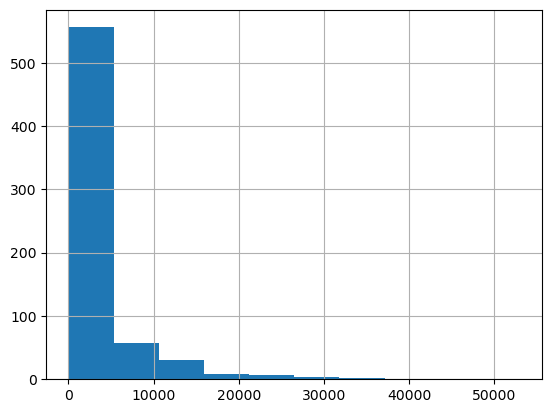

In [9]:
# Plot the runtime distribution of the errors
error["runtime"].dt.seconds.hist()

In [10]:
print("Total errors", len(error))
print("Total successes", len(results))

if len(butter_e_metadata) == len(results) + len(error):
    print("Sum of errors and successes match initial input")

print("Total count of runs:", len(butter_e_metadata))
print("==============")

Total errors 665
Total successes 40464
Sum of errors and successes match initial input
Total count of runs: 41129


<!-- ### No energy data found for given SLURM job id.

- 123 such runs.
- I manually hit hpcmon for a subsample of the slurm_job_ids, and verify that the API returns nothing. Just "[]".
- TODO: Query hpcmon on yuma to see if these jobs were maybe cancelled quickly?

### Missing all energy data points for this run.

- 172 such runs
- For example, 6b68e32a-9a73-4ee7-add1-6f5486ae0ac4
    - Power data for SLURM job ID is (Timestamp('2022-09-26 08:20:02-0600', tz='US/Mountain'), Timestamp('2022-09-28 08:20:01-0600', tz='US/Mountain'))
    - Job data is (Timestamp('2022-10-11 21:58:46.012741+0000', tz='UTC'), Timestamp('2022-10-11 23:29:06.356718+0000', tz='UTC'))

### Missing at least one energy data point for this run. 

- Todo

### At least one of the energy measurements for this run was 0 watts.

- Todo

### Other notes

- end_time is always 2023-02-09, between 4 and 7:30AM

I manually checked https://hpcmon-api.hpc.nrel.gov/api/eagle/jobs/10430519/power/raw and it really has zeros for wattage coming from the API. I checked files on Eagle and they are also zeros. -->

Text(0.5, 1.0, 'Distribution of erroneous runs by batch')

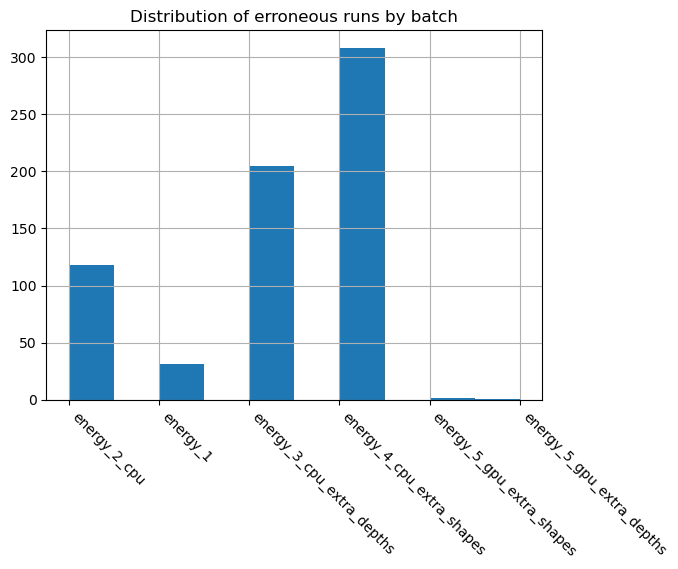

In [11]:
error["batch"].hist()
plt.xticks(rotation=-45, ha="left")
plt.title("Distribution of erroneous runs by batch")